<a href="https://colab.research.google.com/github/CallumPaton/analysing-most-competitve-f1-season/blob/main/F1_data_analysis_result_unpredictability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
# Mount the google drive containing data taken from kaggle (https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020)
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/F1-data-analysis'
driver_standings = pd.read_csv(f'{file_path}/driver_standings.csv')
races = pd.read_csv(f'{file_path}/races.csv')
results = pd.read_csv(f'{file_path}/results.csv')

In [ ]:
driver_standings = driver_standings.merge(races[['raceId','year','round']], on='raceId')
results = results.merge(races[['raceId','year','round']], on='raceId')
driver_standings = driver_standings[(driver_standings['year'] >= 1990) & (driver_standings['year'] < 2023)]
results = results[(results['year'] >= 1990) & (results['year'] < 2023)]

In [ ]:
driver_standings.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins,year,round
0,1,18,1,10.0,1,1,1,2008,1
1,2,18,2,8.0,2,2,0,2008,1
2,3,18,3,6.0,3,3,0,2008,1
3,4,18,4,5.0,4,4,0,2008,1
4,5,18,5,4.0,5,5,0,2008,1


In [ ]:
results.rename(columns={'positionOrder': 'race_position'}, inplace=True)
driver_standings.rename(columns={'position': 'standings_position'}, inplace=True)

# Merge the two DataFrames based on 'raceId', 'driverId', and 'year'
df = pd.merge(results[['raceId', 'driverId', 'year', 'race_position','round']], driver_standings[['raceId', 'driverId', 'year', 'standings_position','round']], on=['raceId', 'driverId', 'year','round'], how='inner')


In [ ]:
from scipy.stats import kendalltau

correlation_df = pd.DataFrame(columns=['raceId','round', 'year', 'correlation'])
# Iterate through unique years
unique_years = df['year'].unique()
for year in unique_years:
    # Filter the data for the current year
    year_data = df[df['year'] == year]

    # Iterate through unique raceIds for the current year
    unique_race_ids = sorted(year_data['raceId'].unique())
    round = 0
    for race_id in unique_race_ids:
        round +=1
        # Select data for the current raceId
        race_data = year_data[year_data['raceId'] == race_id]

        # Calculate Kendall's rank correlation between race_position and standings_position
        correlation, _ = kendalltau(race_data['race_position'], race_data['standings_position'])

        # Append the result to the correlation_df
        correlation_df = correlation_df.append({'raceId': race_id,'round':int(round), 'year': int(year), 'correlation': correlation}, ignore_index=True)

# Display the resulting correlation DataFrame
print(correlation_df)

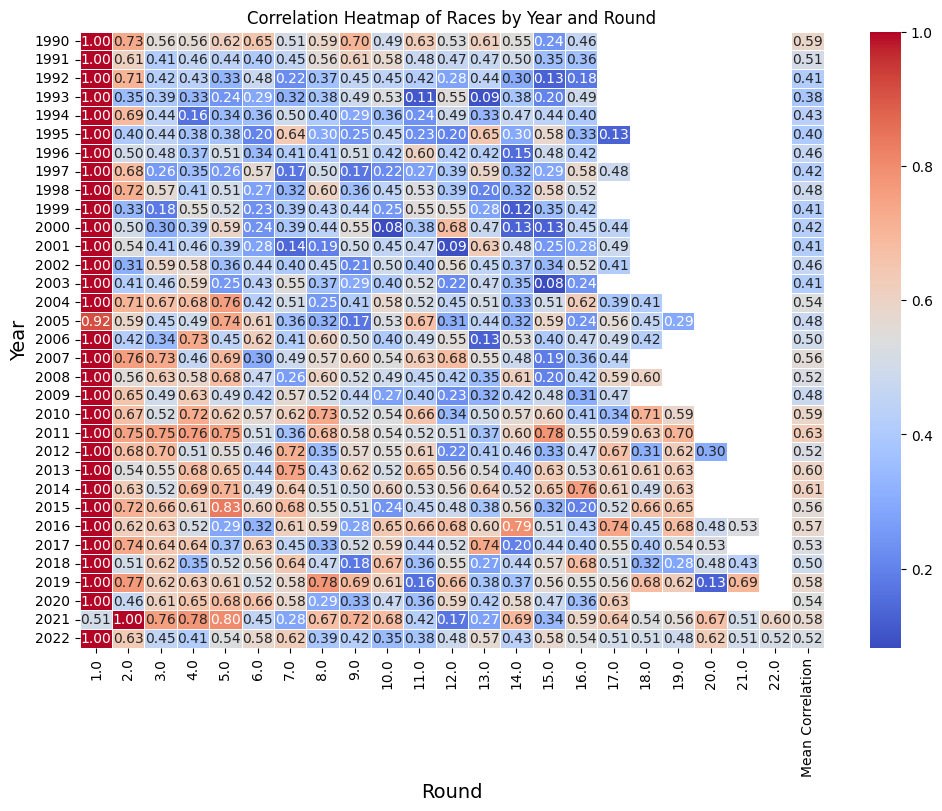

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pivot_matrix = correlation_df.pivot(index='year', columns='round', values='correlation')
# Calculate the mean correlation for each year
pivot_matrix['Mean Correlation'] = pivot_matrix.mean(axis=1)
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

ax = sns.heatmap(pivot_matrix, cmap='coolwarm', annot=True, fmt='.2f', cbar=True, linewidths=.5)

# Set the y-axis tick positions and labels explicitly
years_range = range(1990, 2023)  # Specify the desired range of years
ax.set_yticks(np.arange(len(years_range))+0.5)
ax.set_yticklabels(years_range)

plt.title('Correlation Heatmap of Races by Year and Round')
plt.xlabel('Round', fontsize=14)
plt.ylabel('Year',fontsize=14)

plt.show()
